In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [4]:
# Walk through each directory
dataset = "baru"
walk_through_dir(dataset)

There are 2 directories and 0 images in 'baru'.
There are 5 directories and 0 images in 'baru\Training'.
There are 0 directories and 888 images in 'baru\Training\BercakHitam'.
There are 0 directories and 869 images in 'baru\Training\BukanDaunAnggur'.
There are 0 directories and 814 images in 'baru\Training\DaunSehat'.
There are 0 directories and 828 images in 'baru\Training\HawarDaun'.
There are 0 directories and 855 images in 'baru\Training\KaratDaun'.
There are 5 directories and 0 images in 'baru\validation'.
There are 0 directories and 204 images in 'baru\validation\BercakHitam'.
There are 0 directories and 189 images in 'baru\validation\BukanDaunAnggur'.
There are 0 directories and 190 images in 'baru\validation\DaunSehat'.
There are 0 directories and 197 images in 'baru\validation\HawarDaun'.
There are 0 directories and 184 images in 'baru\validation\KaratDaun'.


In [5]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [6]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("DatasetAnggur").rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

In [7]:
image_df

,Filepath,Label
0,baru\Training\BercakHitam\BercakHitam_color_10...,BercakHitam
1,baru\Training\BercakHitam\BercakHitam_color_10...,BercakHitam
2,baru\Training\BercakHitam\BercakHitam_color_10...,BercakHitam
3,baru\Training\BercakHitam\BercakHitam_color_10...,BercakHitam
4,baru\Training\BercakHitam\BercakHitam_color_10...,BercakHitam
...,...,...
10431,baru\validation\KaratDaun\KaratDaun_color_213_...,KaratDaun
10432,baru\validation\KaratDaun\KaratDaun_color_214_...,KaratDaun
10433,baru\validation\KaratDaun\KaratDaun_color_214_...,KaratDaun
10434,baru\validation\KaratDaun\KaratDaun_color_214_...,KaratDaun


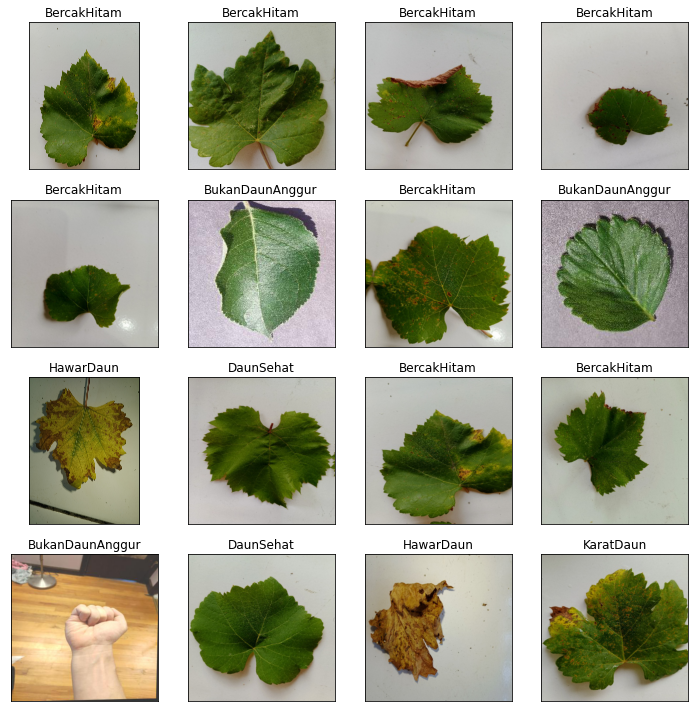

In [8]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
        
    items = list(items)
        
    p = random.choice(items)
    return p.as_posix()

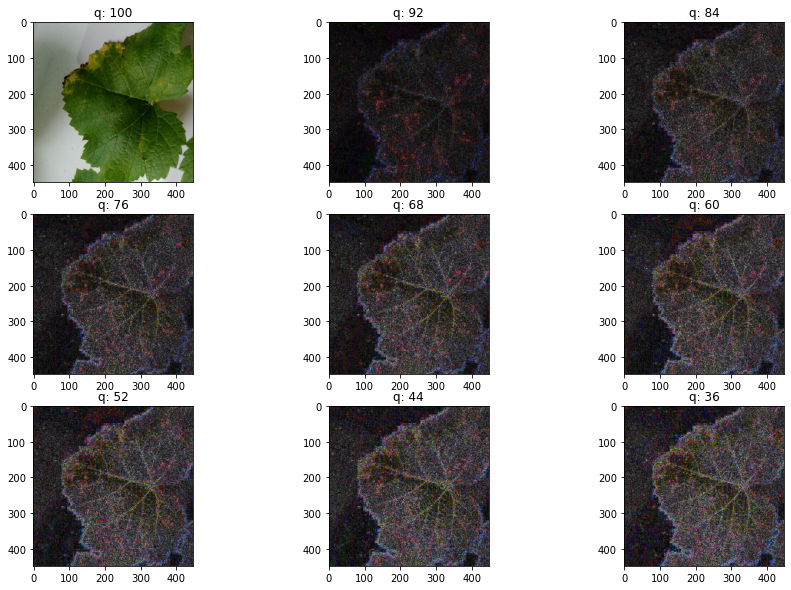

In [10]:
# View random sample from the dataset
p = random_sample('baru\\validation\\BercakHitam')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i) 
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

In [11]:
from tensorflow.keras.applications import MobileNetV2, NASNetMobile, ResNet50V2, EfficientNetB0, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
TRAINING_DIR = "baru//Training"
VALIDATION_DIR = "baru//validation"

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        target_size=(224, 224))

Found 4254 images belonging to 5 classes.
Found 964 images belonging to 5 classes.


In [13]:
print(train_generator.class_indices)

{'BercakHitam': 0, 'BukanDaunAnggur': 1, 'DaunSehat': 2, 'HawarDaun': 3, 'KaratDaun': 4}


In [14]:
# Pretrain Model
pre_trained_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable = False

In [15]:
model = tf.keras.Sequential([
    pre_trained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

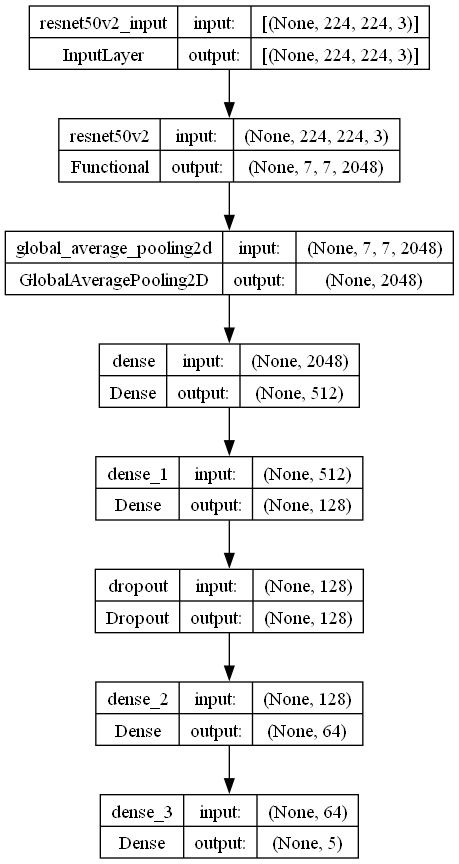

In [16]:
from tensorflow.keras.utils import plot_model

# visualisasi model
plot_model(model, to_file='model.png', show_shapes=True)

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                        

In [18]:
int_lr = 0.0001
num_epochs = 100

# Early Stopping
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Model Checkpoint
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Compile and Training
optimizer = tf.optimizers.Adam(learning_rate=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[earlystop_callback, checkpoint_callback]
)

Epoch 1/100
133/133 [==============================] - ETA: 0s - loss: 0.9190 - accuracy: 0.6215
Epoch 1: val_accuracy improved from -inf to 0.75622, saving model to best_weights.h5
133/133 [==============================] - 447s 3s/step - loss: 0.9190 - accuracy: 0.6215 - val_loss: 0.6462 - val_accuracy: 0.7562
Epoch 2/100
133/133 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.7804
Epoch 2: val_accuracy improved from 0.75622 to 0.82365, saving model to best_weights.h5
133/133 [==============================] - 414s 3s/step - loss: 0.5671 - accuracy: 0.7804 - val_loss: 0.5075 - val_accuracy: 0.8237
Epoch 3/100
133/133 [==============================] - ETA: 0s - loss: 0.4509 - accuracy: 0.8244
Epoch 3: val_accuracy improved from 0.82365 to 0.83817, saving model to best_weights.h5
133/133 [==============================] - 409s 3s/step - loss: 0.4509 - accuracy: 0.8244 - val_loss: 0.4382 - val_accuracy: 0.8382
Epoch 4/100
133/133 [==============================]

133/133 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9984Restoring model weights from the end of the best epoch: 23.

Epoch 28: val_accuracy did not improve from 0.93257
133/133 [==============================] - 500s 4s/step - loss: 0.0111 - accuracy: 0.9984 - val_loss: 0.2641 - val_accuracy: 0.9263
Epoch 28: early stopping


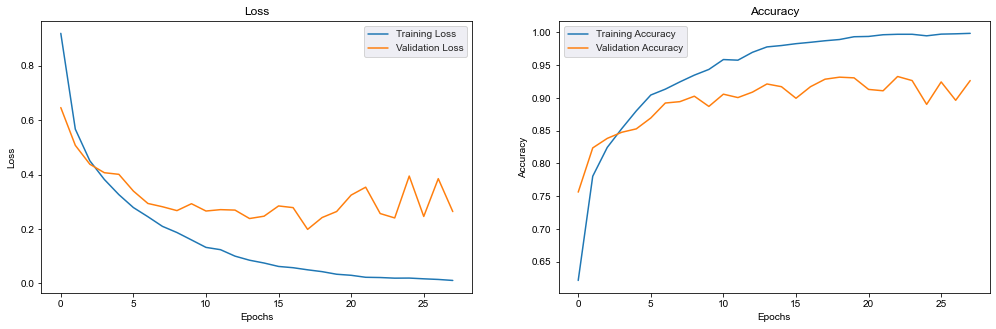

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat list nilai loss dan akurasi dari model
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
train_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

# Membuat plot
fig, ax = plt.subplots(1,2, figsize=(17,5))
sns.set_style("darkgrid")

# Plot loss
ax[0].plot(train_loss, label='Training Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss')
ax[0].legend()

# Plot accuracy
ax[1].plot(train_acc, label='Training Accuracy')
ax[1].plot(val_acc, label='Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [20]:
# Load weights
model.load_weights('best_weights.h5')

# Evaluate model on validation set
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print('Validation Accuracy: {:.2%}'.format(accuracy))
print('Validation Loss: {:.2f}'.format(loss))

31/31 [==============================] - 54s 2s/step - loss: 0.2569 - accuracy: 0.9326
Validation Accuracy: 93.26%
Validation Loss: 0.26


In [21]:
# Mendapatkan label yang sesuai dengan prediksi
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}

In [22]:
# Memuat bobot terbaik yang disimpan selama pelatihan
model.load_weights('best_weights.h5')

# Mengumpulkan semua prediksi dan label asli
y_pred = []
labels = []
for i in range(len(validation_generator)):
    batch_data, batch_labels = validation_generator[i]
    batch_pred = model.predict(batch_data)
    y_pred.extend(np.argmax(batch_pred, axis=1))
    labels.extend(np.argmax(batch_labels, axis=1))

1/1 [==============================] - 1s 1s/step


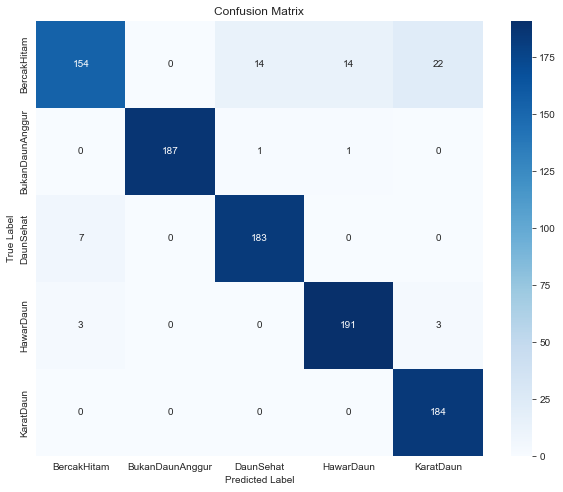

Classification Report:
                 precision    recall  f1-score   support

    BercakHitam       0.94      0.75      0.84       204
BukanDaunAnggur       1.00      0.99      0.99       189
      DaunSehat       0.92      0.96      0.94       190
      HawarDaun       0.93      0.97      0.95       197
      KaratDaun       0.88      1.00      0.94       184

       accuracy                           0.93       964
      macro avg       0.93      0.94      0.93       964
   weighted avg       0.93      0.93      0.93       964



In [23]:
# Menghitung matriks kebingungan
cm = confusion_matrix(labels, y_pred)

# Menghitung akurasi
accuracy = np.sum(labels == y_pred) / len(labels)

# Membuat plot matriks kebingungan
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Mencetak laporan klasifikasi
classification_report_str = classification_report(labels, y_pred, target_names=class_labels.values())
print("Classification Report:")
print(classification_report_str)

In [24]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# Convert SavedModel menjadi .tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('92_resnet.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


98596980